## Import libraries for initial data exploration

In [ ]:
#This is an updated version

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import zipfile

import numpy as np
import gzip
from io import StringIO;
import os

import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import seaborn as sns 

from os import listdir
from os.path import isfile, join
import gzip
import shutil
import pickle
import random

## Read and visualize an input file

### Provide the root directory for where the user input files are, relative to the notebook location

In [2]:
root_dir = "ExtraSensory.per_uuid_features_labels/"

### File parser helper functions

In [3]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index(b'\n')];
    columns = headline.split(b',');

    # The first column should be timestamp:
    assert columns[0] == b'timestamp';
    
    # The last column should be label_source:
    assert columns[-1] == b'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith(b'label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith(b'label:');
        label_names[li] = label.replace(b'label:',b'');
        pass;
    
    return (feature_names, label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str.decode("utf-8")),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s%s.features_labels.csv.gz' % (root_dir, uuid);

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        pass;
    
    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

## Read and store all the file data

### Now that we've explored the dataset, we can store the rest of the files for processing.

In [4]:
onlyfiles = [f for f in listdir(root_dir)]
final_files = [] 
for i in onlyfiles: 
    #x = '/%s%s' % (root_dir, i[0:len(i)-3]) 
    if ".csv" in i and ".gz" not in i:
        final_files.append(i)

In [5]:
if os.path.isfile("./sensor.pkl") and  os.path.isfile("./labels.pkl"):
    with open("./sensor.pkl", "rb") as f:
        sensor_data= pickle.load(f)
    with open("./labels.pkl", "rb") as f:
        labels_data= pickle.load(f) 
else:       
    raw_d = pd.read_csv('./'+root_dir + final_files[0] )
    sensor_data = raw_d.iloc[:,1:225]
    labels_data = raw_d.iloc[:,226:-1]

    for i in range(1,len(final_files)):
        raw_d = pd.read_csv('./'+root_dir + final_files[i] )
        sensor_data = sensor_data.append(raw_d.iloc[:,1:225],ignore_index=True)
        labels_data = labels_data.append(raw_d.iloc[:,226:-1],ignore_index=True)
    with open("./sensor.pkl", "wb") as f:
        pickle.dump(sensor_data,f)
    with open("./labels.pkl", "wb") as f:
        pickle.dump(labels_data,f)


### Fill NaN with column mode, and drop remaining NaN

In [6]:
sensor_data = sensor_data.fillna(0)
labels_data = labels_data.fillna(0)

In [7]:
labels_data.head()

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
sensor_data.head()

,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,lf_measurements:battery_level,lf_measurements:screen_brightness,lf_measurements:temperature_ambient,discrete:time_of_day:between0and6,discrete:time_of_day:between3and9,discrete:time_of_day:between6and12,discrete:time_of_day:between9and15,discrete:time_of_day:between12and18,discrete:time_of_day:between15and21,discrete:time_of_day:between18and24
0,1.026050,0.004956,-0.011147,0.020062,1.024622,1.026169,1.027758,0.784843,6.684600,5.043212,...,0.90,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.026225,0.064620,-0.061327,0.172650,1.022154,1.024484,1.026789,0.671550,6.682509,5.040791,...,0.90,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.026042,0.013626,0.013009,0.035978,1.023549,1.025964,1.027842,0.583047,6.684524,5.042936,...,0.90,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.027755,0.048011,0.056932,0.106184,1.021865,1.024913,1.027899,0.921563,6.683540,5.038209,...,0.89,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1.026951,0.004087,-0.004915,0.012900,1.025302,1.026997,1.028592,0.914141,6.684604,5.043455,...,0.89,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Visualize data before normalization

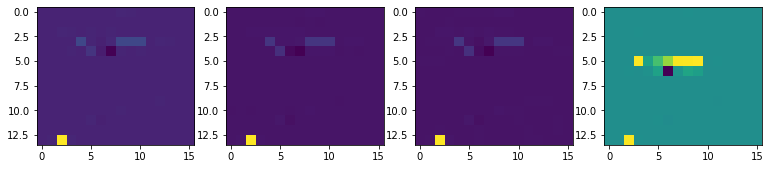

In [9]:
plt.figure(figsize = (13, 6))
plt.title('Unnormalizaed data')
for i in range(4): 
    ax = plt.subplot(1, 4, i+1)
    row_i = sensor_data.iloc[i,:].to_numpy().reshape(14, 16)
    ax.imshow(row_i)

### Normalize the data

In [10]:
per_col_mean = []
per_col_std = []
def normalize_data(data):
    norm_data = pd.DataFrame() 
    for col in data.columns: 
        col_mean = data[col].mean()
        col_std = data[col].std()
        per_col_mean.append(col_mean)
        per_col_std.append(col_std)
        if col_std != 0:
            norm_data[col] = (data[col] - col_mean)/col_std
        else:
            norm_data[col] = data[col]    
    #norm_data.dropna(inplace = True, axis = 'columns' )
    return norm_data
def normalize_test_data(data):
    norm_data = pd.DataFrame() 
    i  = 0
    for col in data.columns: 
        col_mean = per_col_mean[i]
        col_std = per_col_std[i]
        if col_std != 0:
            norm_data[col] = (data[col] - col_mean)/col_std
        else:
            norm_data[col] = data[col]   
        i = i +1
    
    #norm_data.dropna(inplace = True, axis = 'columns' )
    return norm_data


### Store the Input Shape

In [11]:
input_shape = 224
input_shape_s1 = 14
input_shape_s2 = 16

### Create a SensorDataset class that can be used to store the data

In [12]:
class SensorDataset(Dataset): 
    
    def __init__(self, sensor_data, transform,labels_data):
        """provide directory with the user's data"""
        self.sensor_data = sensor_data
        self.transform = transform
        self.labels_data = labels_data
        
    def __len__(self):
        return len(self.sensor_data)
        
    # This function can be used to index into the dataset
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                 

        sample =  self.sensor_data.iloc[idx,:]
        labels =  self.labels_data.iloc[idx,:]
        
        if self.transform:
            # Transform to tensor
            sample = self.transform(sample.to_numpy().reshape(input_shape_s1, input_shape_s2))
            
        return sample, torch.from_numpy(labels.to_numpy())

### Define the batch size parameter

In [13]:
batch_size = 64

### Create the training & test datasets

In [14]:
def create_train_test_sets(sensor_data,labels=None):
    img_transform = transforms.Compose([
        transforms.ToTensor()])
    #     transforms.Lambda(lambda tensor:min_max_norm(tensor, 0, 1)),
    #     transforms.Lambda(lambda tensor:reshape_img(tensor,11,20))

#     sensor_data=sensor_data.fillna(0)
#     sensor_data[sensor_data == "nan"] = 0
    dataset_size = len(sensor_data)
    
    
    all_indices = [i for i in range(dataset_size)]
    random.shuffle(all_indices) #pick random trainig samples
    row_train = all_indices[:int(2*dataset_size/3)]
    row_test = all_indices[int(2*dataset_size/3):]

    # Indexes for 0 -> 2/3 of dataset_size
#     row_train = [i for i in range(int(2*dataset_size/3))]
    train_data = sensor_data.loc[row_train,:]

    # Indexes for 2/3 dataset_size -> end
#     row_test = [i for i in range(int(2*dataset_size/3),dataset_size)] 
    test_data = sensor_data.loc[row_test,:]
    
    train_data = normalize_data(train_data)
    test_data = normalize_test_data(test_data)
#  Note the the number of columns has changed from the data set without normalization
    
    print(len(train_data))
    print(len(test_data))

    train_data = SensorDataset(train_data, transform = img_transform,labels_data=labels.loc[row_train,:])
    test_data = SensorDataset(test_data, transform = img_transform,labels_data=labels.loc[row_test,:])
    
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True)
    
    return train_data, test_data, train_loader, test_loader


In [15]:
train_data, test_data, train_loader, test_loader = create_train_test_sets(sensor_data, labels = labels_data)

251564
125782


## Visualize the training data as images

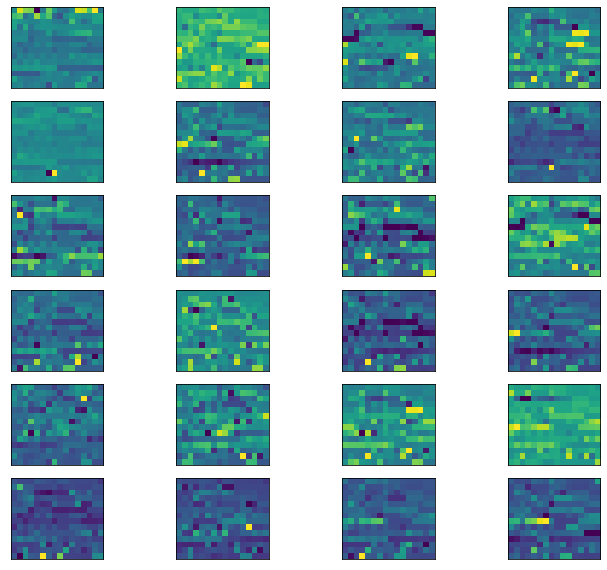

In [16]:
fig = plt.figure(figsize=(10, 8))
count = 0 
for i in range(24):
    ax = plt.subplot(6,4,count+1)
    
    im = train_data[count][0]
    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.imshow(im.numpy().squeeze())
    count +=1
    
fig.tight_layout(pad=1.0)


## Process the data with an Autoencoder

### Initialize the Autoencoder variables and hyperparameters

In [17]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Create Autoencoder class

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8,2),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(8,16,2),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            
            nn.Conv2d(16,32,2),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,3),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,16,(2,3)),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,8,3),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,8,3),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,3,3),
            nn.ReLU(True),
            nn.ConvTranspose2d(3,3,3),
            nn.ReLU(True),
            nn.ConvTranspose2d(3,1,3)
#             nn.UpsamplingBilinear2d(2),
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def forward_encoder_only(self,x):
        return self.encoder(x)

In [19]:
model = Autoencoder()

In [20]:
print((10,1,input_shape_s1, input_shape_s2))
print(model(torch.rand(10,1,input_shape_s1, input_shape_s2)).shape)

(10, 1, 14, 16)
torch.Size([10, 1, 14, 16])


### Leverage GPU, if available

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
print(device)

cuda


### Create an autoencoder instance

In [23]:
model = Autoencoder().to(device)

## Train the autoencoder

### Define the `fit()` method

In [24]:
print(len(test_loader),len(train_loader))

1966 3931


In [26]:
def fit(current_epoch):
    model.train()
    
    # Reset local variables
    loss = 0
    count = 0

    # Iterate through the training dataset
    for batch_features,y_obs in train_loader:
        count +=1
        # Reshape mini-batch data to [N, ch, w,h] matrix
        batch_features = batch_features.to(device)
        # Reset the gradients back to zero
        optimizer.zero_grad()

        # Compute reconstructions
        y_pred = model(batch_features.float())

        # Compute training reconstruction loss
        train_loss = criterion(y_pred, batch_features.float())

        # Compute accumulated gradients
        train_loss.backward()

        # Perform parameter update based on current gradients
        optimizer.step()

        # Add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        if count%500==0:
            print("\t \t -->: Training loss = {:.6f}".format(loss/count)) 


    # Compute the average training loss across the epoch
    loss = loss / len(train_loader)
    
    # Return the loss for this iteration
    return loss

### Define a validate function

In [27]:
def validate(current_epoch):
    model.eval()
    
    # Reset local variables
    loss = 0 
    count = 0    
    
    # Iterate through the test dataset (we are using this data for validation, too)
    for batch_features, y_obs in test_loader:
        count+=1
        # Reshape mini-batch data to [N, input_shape] matrix
        batch_features = batch_features.to(device)
        
        # Use the model
        y_pred = model(batch_features.float())
        
        # Test loss
        val_loss = criterion(batch_features.float(), y_pred)

        # Add the mini-batch training loss to epoch loss
        loss += val_loss.item()
        if count%500==0:
            print("\t \t-->: Validation loss = {:.6f}".format(loss/count)) 

    # Compute the average training loss across the epoch
    loss = loss / len(test_loader)
    
    # Return the loss for this iteration
    return loss

### Run the fit and validation functions

In [29]:
# Define parameters for autoencoder
num_epochs = 100
learn_rate = 1e-3
train_loss_array = []
validate_loss_array = []
optimizer = optim.Adadelta(model.parameters())
criterion = nn.MSELoss()

min_val_loss = 100000000
min_val_epoch = 1

# Create a directory to store the best 
checkpoint_dir = './checkpoint/autoencoder/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Iterate through all epochs
for current_epoch in range(num_epochs):
    
    # Train & validate for the current epoch
    fit_loss = fit(current_epoch)
    train_loss_array.append(fit_loss)
    print("Epoch {}/{}: Training loss = {:.6f}".format(current_epoch + 1, num_epochs, fit_loss)) 

    val_loss = validate(current_epoch)
    validate_loss_array.append(val_loss)
    print("Epoch {}/{}: Validation loss = {:.6f}".format(current_epoch + 1, num_epochs, val_loss)) 
    
    if validate_loss_array[-1] < min_val_loss:
        min_val_loss =  validate_loss_array[-1]
        min_val_epoch = current_epoch
        
        torch.save(model.state_dict(), checkpoint_dir + 'val_best_cnn.pth') 

print(min_val_loss)
print(min_val_epoch + 1)

	 	 -->: Training loss = 0.996050
	 	 -->: Training loss = 1.003727
	 	 -->: Training loss = 0.994581
	 	 -->: Training loss = 0.995492
	 	 -->: Training loss = 0.987525
	 	 -->: Training loss = 0.986568
	 	 -->: Training loss = 0.981658
Epoch 1/100: Training loss = 0.982183
	 	-->: Validation loss = 0.976622
	 	-->: Validation loss = 0.976725
	 	-->: Validation loss = 0.979828
Epoch 1/100: Validation loss = 5.325736
	 	 -->: Training loss = 0.969076
	 	 -->: Training loss = 0.969275
	 	 -->: Training loss = 0.973486
	 	 -->: Training loss = 0.980124
	 	 -->: Training loss = 0.979346
	 	 -->: Training loss = 0.977134
	 	 -->: Training loss = 0.978099
Epoch 2/100: Training loss = 0.982161
	 	-->: Validation loss = 0.976328
	 	-->: Validation loss = 9.525914
	 	-->: Validation loss = 6.671325
Epoch 2/100: Validation loss = 5.324861
	 	 -->: Training loss = 0.996882
	 	 -->: Training loss = 0.989277
	 	 -->: Training loss = 0.984783
	 	 -->: Training loss = 0.983172
	 	 -->: Training loss

KeyboardInterrupt: 

### Visualize how loss changes with # of epochs for training data 

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.tight_layout()
ax1.plot(train_loss_array, label = "Training Loss")
ax1.plot(validate_loss_array, label = "Validation Loss")

plt.xlabel("Number of Epochs")
plt.ylabel("Average loss for the epoch")
plt.title("Epoch v. Loss")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Test the dataset

In [ ]:
test_examples = None
reconstruction = None

with torch.no_grad():
    for batch_features,_ in test_loader:
        test_examples = batch_features.view(-1, input_shape)
        reconstruction = model(test_examples.float())
        break

### Visualize the results

In [ ]:
print(test_examples.shape)
print(reconstruction.shape)

In [ ]:
with torch.no_grad():
    number = 4
    plt.figure(figsize=(12, 6))
    for index in range(number):
        
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(input_shape_s1, input_shape_s2))
        plt.title('Original #' + str(index + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstructed
        ax = plt.subplot(2, number, index + 1+ number)
        plt.imshow(reconstruction[index].numpy().reshape(input_shape_s1, input_shape_s2))
        plt.title('Reconstructed #' + str(index + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

In [ ]:
t = [i for i in range(input_shape)]
count = 0 
with torch.no_grad():
    number = 4
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    for index in range(number):
        # display original
        ax = plt.subplot(1, number, index + 1)
        sensor_read = test_examples[index].numpy().reshape(input_shape, 1)
        plt.title('Sample #' + str(index + 1))
        plt.xlabel('Feature')
        plt.ylabel('Value')
        plt.subplot(ax)
        plt.plot(t, sensor_read, color = 'b', label = 'Actual')

        sensor_read_rec = reconstruction[index].numpy().reshape(input_shape, 1)
        plt.plot(t, sensor_read_rec, color = 'r', label = 'Reconstructed'); 

plt.legend(loc ='best')
plt.show() 

# Run the Autoencoder logic for all the files

In [ ]:
encoded_vals = [j for j in range(len(final_files))]
count = 0
reconstruction = []

for file in final_files:
    print("file: ", file)
    if (file.endswith('.cs')):
        continue
       
    raw_d = pd.read_csv('.' + file + '.csv')
    
    input_shape = raw_d.shape[1]
    labels_shape = input_shape
    
    sensor_data = raw_d.iloc[:,1 : input_shape + 1]
    sensor_data = remove_and_fill_nan(sensor_data)
    labels_data = raw_d.iloc[:, labels_shape:-1]
    labels_data = remove_and_fill_nan_zero(labels_data)
    norm_sensor_data = normalize_data(sensor_data)
    train_data_set, test_data_set, train_dataset_loader, test_dataset_loader = create_train_test_sets(norm_sensor_data,labels_data)

    # Use the Autoencoder that only encodes
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    input_shape = norm_sensor_data.shape[1]
    input_shape_s1 = 26 
    input_shape_s2 = 10
    model = Autoencoder(input_shape = input_shape).to(device)
    
    # Use the Autoencoder that both encodes and decodes
    # model = Autoencoder(input_shape = input_shape).to(device)
    
    # loss_results = fit(num_epochs = 20, learn_rate = 1e-3)
    
    reconstruction.append([])
    with torch.no_grad():
        for batch_features, y_obs in test_dataset_loader:
            test_examples = batch_features.view(-1, input_shape)
            reconstruction[count] = model(test_examples.float())
            break
    
    encoded_vals[count] = model(test_examples.float())
    count += 1
    break

print("Envoded vals: \n", encoded_vals[0])